In [1]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
import os
import re
from sklearn.preprocessing import LabelEncoder

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Feature Extraction

In [5]:
#feature extraction function

def extract_features(segment_df, columns_to_extract):
    features = {}

    for channel in columns_to_extract:
        signal = segment_df[channel].values

        # Mean
        features[f'{channel}_mean'] = np.mean(signal)

        # Standard Deviation
        features[f'{channel}_std'] = np.std(signal)

        # Skewness
        features[f'{channel}_skew'] = skew(signal)

        # Kurtosis
        features[f'{channel}_kurt'] = kurtosis(signal)

        # Zero Crossing Rate
        zcr = np.sum(np.diff(np.sign(signal)) != 0)
        features[f'{channel}_zcr'] = zcr

        # Line Length
        line_length = np.sum(np.abs(np.diff(signal)))
        features[f'{channel}_line_length'] = line_length

        # Hjorth Activity (variance of the signal)
        features[f'{channel}_hjorth_activity'] = np.var(signal)

        # Hjorth Mobility
        derivative = np.diff(signal)
        features[f'{channel}_hjorth_mobility'] = np.sqrt(np.var(derivative) / np.var(signal))

        # Hjorth Complexity
        features[f'{channel}_hjorth_complexity'] = np.sqrt(np.var(np.diff(derivative)) / np.var(derivative)) / features[f'{channel}_hjorth_mobility']

    return features


In [6]:
# Columns to use for feature extraction

columns_to_extract = ['RAW_AF7', 'RAW_AF8', 'RAW_TP9', 'RAW_TP10']

# Define data path and label encoder
data_path = '/content/drive/MyDrive/EEGproject/segmented_data'
gender_encoder = LabelEncoder()
gender_encoder.fit(['M', 'F'])

# Lists to hold feature data and labels
X = []
y = []

# Loop through the files and process each CSV
for filename in os.listdir(data_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(data_path, filename)

        # Read CSV with no header, assign column names
        eeg_columns = [
            'TimeStamp', 'Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10',
            'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10',
            'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10',
            'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10',
            'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10',
            'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10',
            'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z',
            'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn',
            'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10',
             'Gender', 'Burnout'
        ]
        df = pd.read_csv(file_path, header=None, names=eeg_columns)

        # Encode gender (assumes it's constant per file)
        gender_str = df['Gender'].iloc[0]
        gender_encoded = gender_encoder.transform([gender_str])[0]

        # Drop columns not needed (but keep gender)
        drop_cols = ['TimeStamp', 'Burnout']
        features_df = df.drop(columns=drop_cols, errors='ignore')

        # Replace Gender column with encoded value
        features_df['Gender'] = gender_encoded

        # Extract features for the specified columns
        features = extract_features(features_df, columns_to_extract)

        # Add the gender and burnout label
        features['Gender'] = gender_encoded
        burnout_label = df['Burnout'].iloc[0]
        features['Burnout'] = burnout_label

        # Append the features and label to the lists
        X.append(features)
        y.append(burnout_label)

<ipython-input-5-314a0bd11ac3>:16: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features[f'{channel}_skew'] = skew(signal)
<ipython-input-5-314a0bd11ac3>:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  features[f'{channel}_kurt'] = kurtosis(signal)
<ipython-input-5-314a0bd11ac3>:37: RuntimeWarning: invalid value encountered in scalar divide
  features[f'{channel}_hjorth_complexity'] = np.sqrt(np.var(np.diff(derivative)) / np.var(derivative)) / features[f'{channel}_hjorth_mobility']
<ipython-input-5-314a0bd11ac3>:34: RuntimeWarning: invalid value encountered in scalar divide
  features[f'{channel}_hjorth_mobility'] = np.sqrt(np.var(derivative) / np.var(signal))


Save Extracted features

In [8]:
# Convert the extracted features and labels into DataFrame
features_df = pd.DataFrame(X)

# Add the burnout label column to the features DataFrame
features_df['Burnout'] = y

# Define the output file path
output_file_combined = '/content/drive/MyDrive/EEGproject/Extracted_features_and_labels.csv'

# Save the combined DataFrame (features + labels) to CSV
features_df.to_csv(output_file_combined, index=False)

# Print a confirmation message
print(f'Combined features and labels saved to {output_file_combined}')

Combined features and labels saved to /content/drive/MyDrive/EEGproject/Extracted_features_and_labels.csv




---



---



---



>**Process the Data**

Import necessary libraries

In [66]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


Load Dataset (Extracted features and labels)

In [44]:
data = pd.read_csv('/content/drive/MyDrive/EEGproject/features_and_labels_combined.csv')

In [45]:
data.head()

,RAW_AF7_mean,RAW_AF7_std,RAW_AF7_skew,RAW_AF7_kurt,RAW_AF7_zcr,RAW_AF7_line_length,RAW_AF7_hjorth_activity,RAW_AF7_hjorth_mobility,RAW_AF7_hjorth_complexity,RAW_AF8_mean,...,RAW_TP10_std,RAW_TP10_skew,RAW_TP10_kurt,RAW_TP10_zcr,RAW_TP10_line_length,RAW_TP10_hjorth_activity,RAW_TP10_hjorth_mobility,RAW_TP10_hjorth_complexity,Gender,Burnout
0,837.851234,363.249364,-0.133925,-0.791831,32,902148.282836,131950.100540,1.043700,1.181308,852.325150,...,200.722487,0.008310,-1.366605,0,522113.59429,40289.516816,1.042486,1.116492,0,M
1,859.863155,375.689060,-0.146873,-0.884371,34,932982.930276,141142.269471,1.041248,1.182279,846.986874,...,192.508819,-0.000218,-1.401700,0,498862.89434,37059.645546,1.039516,1.118670,0,M
2,867.124873,374.261371,-0.119546,-0.836457,34,917452.379342,140071.574123,1.032821,1.196030,844.656904,...,183.724459,-0.001297,-1.364500,0,477766.26664,33754.676736,1.042588,1.116947,0,M
3,867.195679,388.309064,-0.127975,-0.938137,40,955775.898425,150783.929215,1.035858,1.197797,846.381043,...,187.964957,0.003007,-1.402264,0,486705.68158,35330.825028,1.038573,1.119007,0,M
4,881.829568,389.367230,-0.114147,-0.896030,38,966416.886578,151606.839500,1.038235,1.186832,846.368122,...,184.042755,0.023104,-1.405510,0,482345.96988,33871.735521,1.048397,1.108735,0,M


In [46]:
data.shape

(1499, 38)

Explotary data analysis

In [47]:
data = data.drop(columns = 'Gender', errors='ignore')
data.shape

(1499, 37)

In [48]:
data.describe()

,RAW_AF7_mean,RAW_AF7_std,RAW_AF7_skew,RAW_AF7_kurt,RAW_AF7_zcr,RAW_AF7_line_length,RAW_AF7_hjorth_activity,RAW_AF7_hjorth_mobility,RAW_AF7_hjorth_complexity,RAW_AF8_mean,...,RAW_TP9_hjorth_complexity,RAW_TP10_mean,RAW_TP10_std,RAW_TP10_skew,RAW_TP10_kurt,RAW_TP10_zcr,RAW_TP10_line_length,RAW_TP10_hjorth_activity,RAW_TP10_hjorth_mobility,RAW_TP10_hjorth_complexity
count,1499.000000,1.499000e+03,1499.000000,1499.000000,1499.000000,1.499000e+03,1.499000e+03,1499.000000,1498.000000,1499.000000,...,1499.000000,1499.000000,1499.000000,1498.000000,1498.000000,1499.000000,1.499000e+03,1499.000000,1498.000000,1498.000000
mean,781.184046,1.737452e+02,0.208655,4.847508,116.769179,3.566466e+05,7.311523e+04,0.629276,4.001379,803.193915,...,2.460923,777.257336,255.598529,0.108670,0.041671,162.618412,6.684041e+05,107307.561929,0.988700,1.648277
std,178.752263,2.072595e+02,1.598153,11.625968,264.657304,6.155385e+05,1.165074e+05,0.425284,3.574255,105.876810,...,1.848074,124.256805,204.951155,0.547758,3.745319,322.535234,7.161597e+05,131825.505546,0.332887,1.066207
min,23.772894,7.105427e-15,-10.792431,-2.000000,0.000000,0.000000e+00,5.048710e-29,0.000000,1.024193,36.494022,...,1.023963,370.387567,0.000000,-2.944912,-1.910062,0.000000,0.000000e+00,0.000000,0.085646,1.020091
25%,806.558544,1.429386e+01,-0.238815,-0.549000,0.000000,9.039745e+03,2.043144e+02,0.270391,1.341291,816.978299,...,1.192536,779.652744,73.705500,-0.056935,-1.281047,0.000000,1.156471e+05,5432.501099,0.819844,1.143937
50%,859.863155,4.833757e+01,0.117165,1.001473,0.000000,1.883780e+04,2.336520e+03,0.528207,2.759002,836.601540,...,1.664828,836.088691,184.611953,0.021122,-0.881116,0.000000,2.958964e+05,34081.573319,1.026317,1.221306
75%,867.469219,3.452796e+02,0.722015,5.085566,46.000000,4.168164e+05,1.192196e+05,0.997973,5.080924,843.243716,...,3.090536,843.293987,478.311128,0.443293,0.142799,34.000000,1.054171e+06,228781.695542,1.091612,1.627093
max,1118.338971,7.769090e+02,10.710617,139.439387,1010.000000,2.253971e+06,6.035876e+05,1.613454,23.240571,1480.530974,...,14.813285,1650.000000,778.105200,3.285015,109.136072,1019.000000,2.327890e+06,605447.702216,1.713494,12.870074


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   RAW_AF7_mean                1499 non-null   float64
 1   RAW_AF7_std                 1499 non-null   float64
 2   RAW_AF7_skew                1499 non-null   float64
 3   RAW_AF7_kurt                1499 non-null   float64
 4   RAW_AF7_zcr                 1499 non-null   int64  
 5   RAW_AF7_line_length         1499 non-null   float64
 6   RAW_AF7_hjorth_activity     1499 non-null   float64
 7   RAW_AF7_hjorth_mobility     1499 non-null   float64
 8   RAW_AF7_hjorth_complexity   1498 non-null   float64
 9   RAW_AF8_mean                1499 non-null   float64
 10  RAW_AF8_std                 1499 non-null   float64
 11  RAW_AF8_skew                1499 non-null   float64
 12  RAW_AF8_kurt                1499 non-null   float64
 13  RAW_AF8_zcr                 1499 

In [50]:
data.isnull().sum()

,0
RAW_AF7_mean,0
RAW_AF7_std,0
RAW_AF7_skew,0
RAW_AF7_kurt,0
RAW_AF7_zcr,0
RAW_AF7_line_length,0
RAW_AF7_hjorth_activity,0
RAW_AF7_hjorth_mobility,0
RAW_AF7_hjorth_complexity,1
RAW_AF8_mean,0


In [51]:
data.dropna(inplace=True)

In [52]:
data.shape

(1498, 37)

In [53]:
data['Burnout'].value_counts()

,count
Burnout,
H,665
M,454
L,379


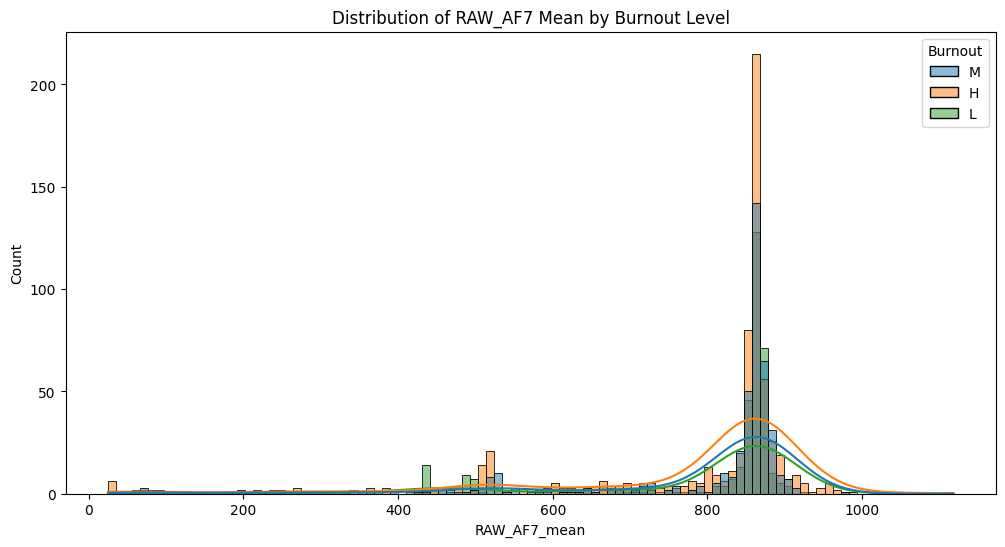

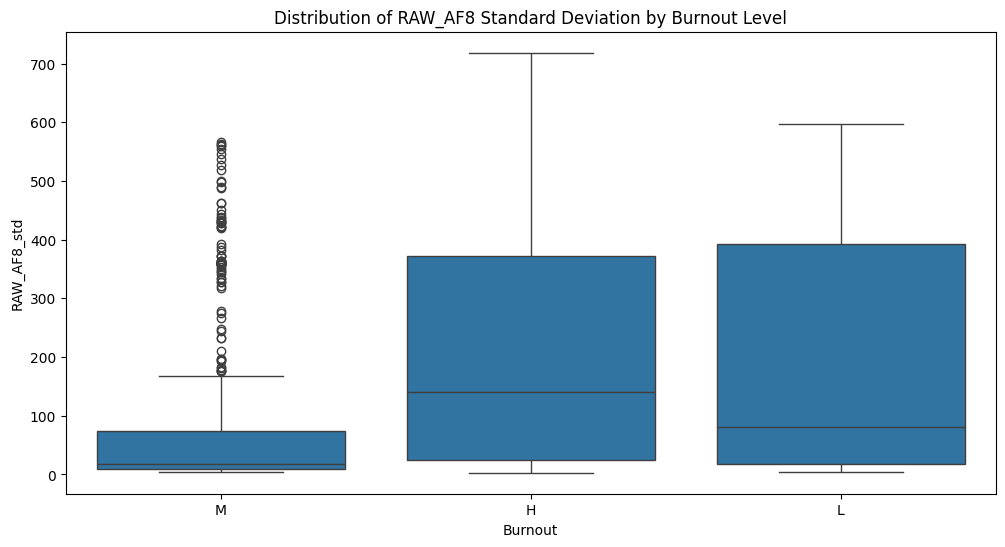

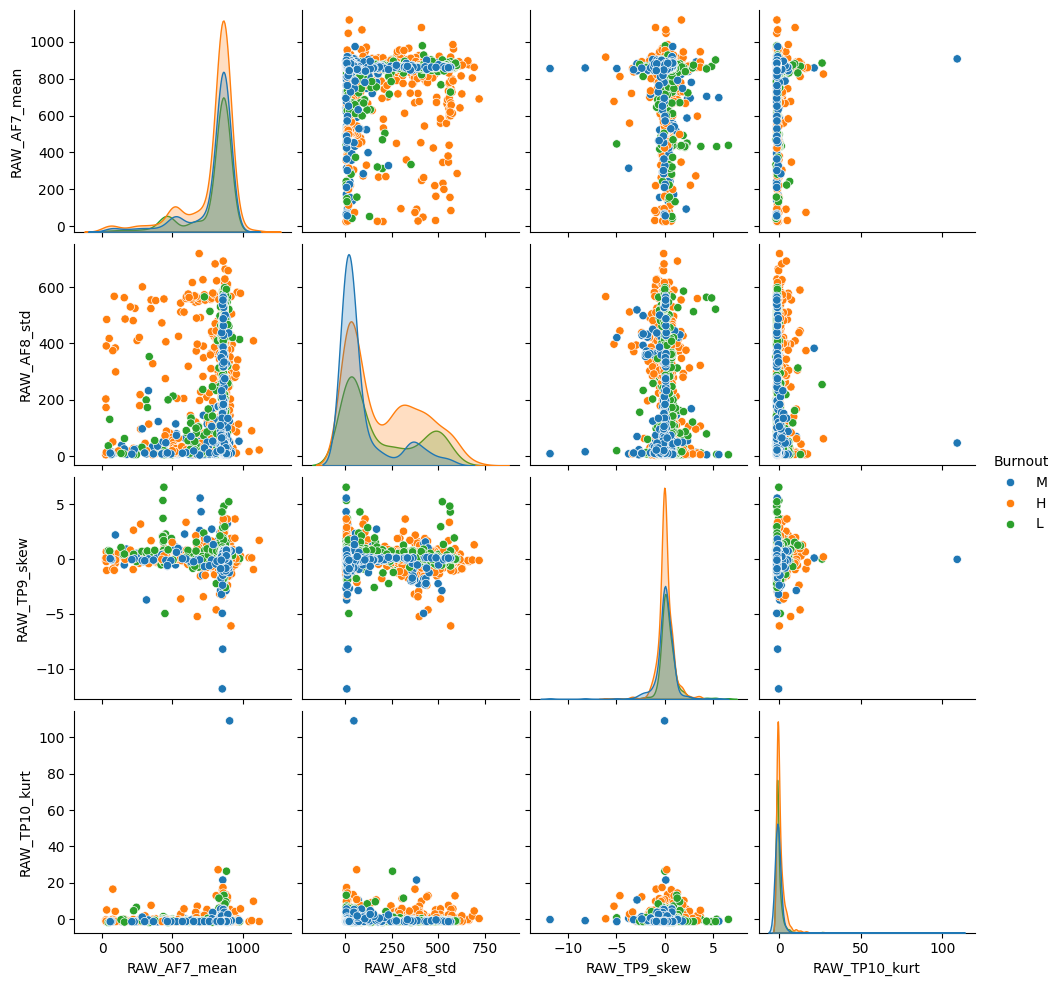

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions of key features for different burnout levels
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='RAW_AF7_mean', hue='Burnout', kde=True)
plt.title('Distribution of RAW_AF7 Mean by Burnout Level')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='Burnout', y='RAW_AF8_std')
plt.title('Distribution of RAW_AF8 Standard Deviation by Burnout Level')
plt.show()

# Pairplot for selected features
selected_features = ['RAW_AF7_mean', 'RAW_AF8_std', 'RAW_TP9_skew', 'RAW_TP10_kurt', 'Burnout']
sns.pairplot(data[selected_features], hue='Burnout')
plt.show()


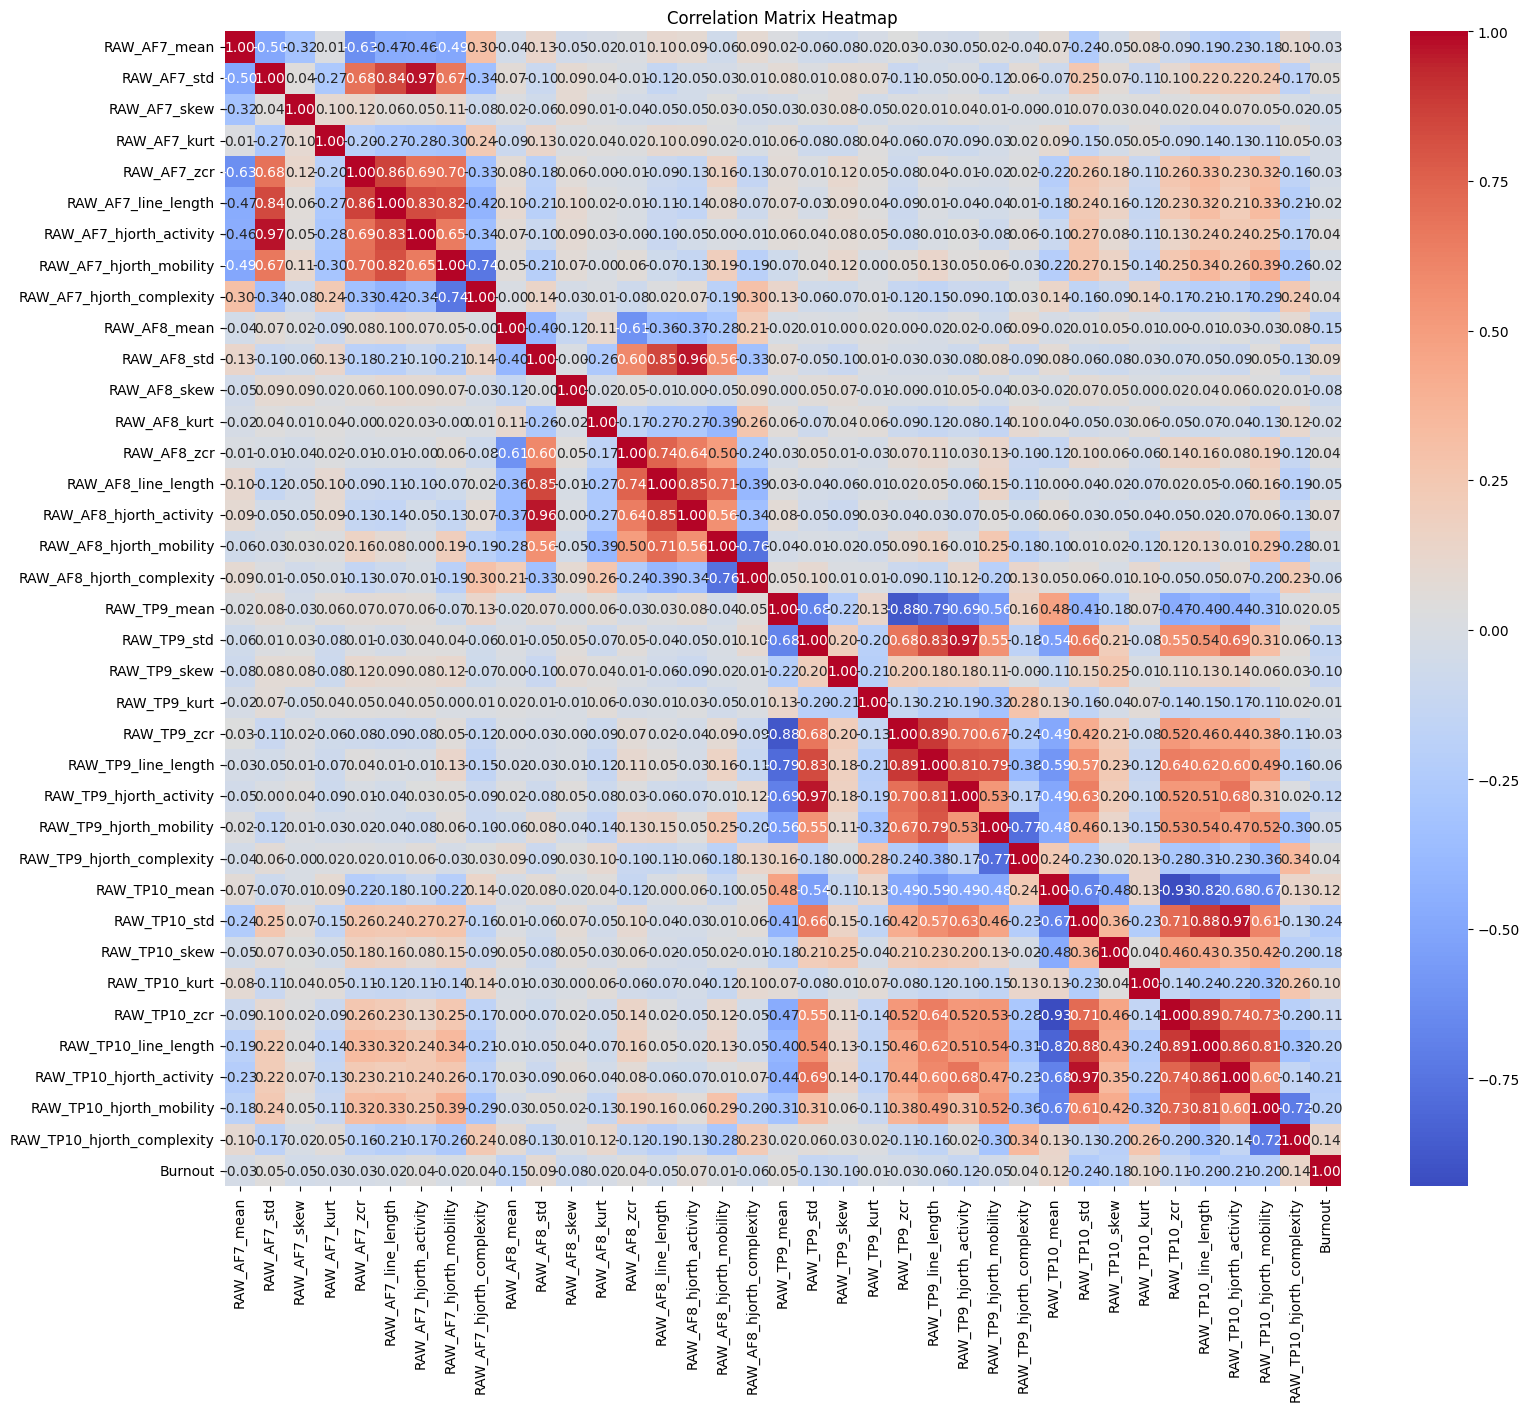

In [55]:
#convert labels
data['Burnout'] = data['Burnout'].map({'L': 0, 'M': 1, 'H': 2})

# Create a correlation matrix
correlation_matrix = data.corr()

# Create a heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

Divide data into features and label

In [56]:
X = data.drop(columns = 'Burnout')
y = data['Burnout']

Feature scaling

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

Training the model

**1. Logistic regression with L2 regularization**

In [72]:
#train model
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

model = LogisticRegression(penalty='l2', C= 4.0, max_iter=1000, solver='lbfgs', multi_class='auto')
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=4.0, max_iter=1000, multi_class='auto')

In [74]:
y_predLg = model.predict(X_test)


In [81]:
#for Logistic regression

print("Accuracy of Logistic regression Model :", accuracy_score(y_test, y_predLg))
print("Classification Report:\n", classification_report(y_test, y_predRf, target_names=[str(i) for i in le.classes_])) # Convert le.classes_ to a list of strings

Accuracy of Logistic regression Model : 0.7
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       114
           1       0.96      0.90      0.93       136
           2       0.90      0.96      0.93       200

    accuracy                           0.92       450
   macro avg       0.93      0.92      0.92       450
weighted avg       0.93      0.92      0.92       450



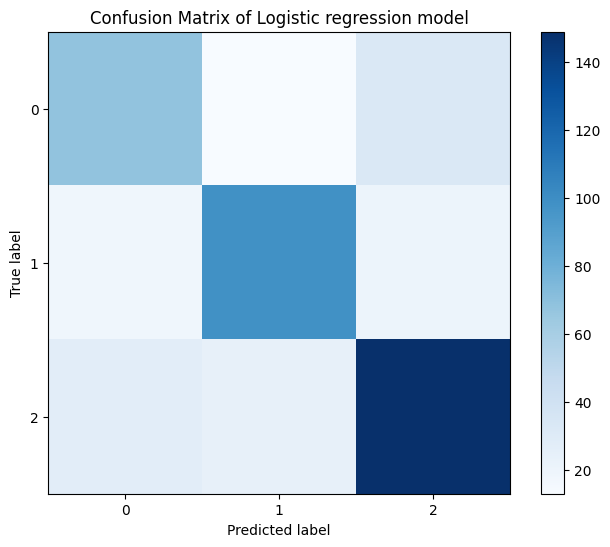

In [83]:
# Plot confusion matrix for Logistic regression

cm = confusion_matrix(y_test, y_predLg)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix of Logistic regression model")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [85]:
# Cross-validation with stratified folds
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate with cross_val_score
cv_scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')

# Output results
print(f"CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

CV Accuracy: 0.6943 (+/- 0.0173)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


**2. Random Forest**

In [73]:
# Train Classifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Make predictions

In [75]:
y_predRf = clf.predict(X_test)

Evaluate model perfomance

In [80]:
#for Logistic regression

print("Accuracy of Random Forest Model :", accuracy_score(y_test, y_predRf))
print("Classification Report:\n", classification_report(y_test, y_predRf, target_names=[str(i) for i in le.classes_])) # Convert le.classes_ to a list of strings

Accuracy of Random Forest Model : 0.9244444444444444
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.89      0.91       114
           1       0.96      0.90      0.93       136
           2       0.90      0.96      0.93       200

    accuracy                           0.92       450
   macro avg       0.93      0.92      0.92       450
weighted avg       0.93      0.92      0.92       450



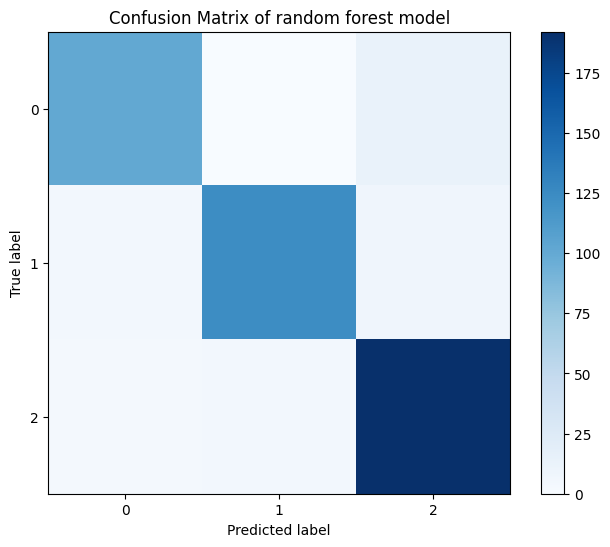

In [84]:
# Plot confusion matrix of Random forest model

cm = confusion_matrix(y_test, y_predRf)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix of random forest model")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [86]:
# Cross-validation with stratified folds
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate with cross_val_score
cv_scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='accuracy')

# Output results
print(f"CV Accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

CV Accuracy: 0.9226 (+/- 0.0058)


# Final Results
*The random forest model is performed well for whole dataset, having accuraccy score of 92.4 percentage and cross-validation score of 92.26 percentage*
